## Assignment 02 - Logistic Regression Classifier using PyTorch on CIFAR-10 Dataset

#### Submitted By:
1. Dhruvan Ganesh
2. Sheikh Mastura Farzana


### Imports

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn import preprocessing
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

### Environment Information

In [2]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = "~/.datasets"
seed = 42

random_seed(seed, torch.cuda.is_available())

print("Device:", device)
if torch.cuda.is_available():
  print("Device Name:", torch.cuda.get_device_name(0))
print("Data Dir:", data_dir)
print("Set Random Seed:", seed)

Device: cuda:0
Device Name: GeForce GTX 1660 Ti
Data Dir: ~/.datasets
Set Random Seed: 42


In [3]:
## Plotting Utils


def plotLine(arr: [], title=""):
    plt.plot(np.squeeze([range(1, len(arr) + 1)]), np.squeeze(arr))
    plt.title(title)
    plt.show()


def plotLines(arr: [], arr2: [], title="", labels=[]):
    plt.plot(np.squeeze([range(1, len(arr) + 1)]), np.squeeze(arr), label=labels[0])
    plt.plot(np.squeeze([range(1, len(arr2) + 1)]), np.squeeze(arr2), label=labels[1])
    plt.title(title)
    plt.legend()
    plt.show()


def plotNumpyArray(ndarray, title="", xlabel=""):
    df = pd.DataFrame(
        ndarray, columns=[f"Param {i}" for i in range(1, ndarray.shape[1] + 1)]
    )
    df.plot.line()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

### Class to load the CIFAR10 dataset

In [4]:
class CIFAR10Data:
    def __init__(self):
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        self.trainset = datasets.CIFAR10(
            root=data_dir, train=True, download=True, transform=transform
        )
        self.testset = datasets.CIFAR10(
            root=data_dir, train=False, download=True, transform=transform
        )

        self.classes = (
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        )

    def get_cifar10_data(self):
        return self.trainset, self.testset, self.classes

    def get_cifar10_batch_loaders(self, batch_size=64):

        train_dataloader = DataLoader(
            self.trainset,
            shuffle=True,
            batch_size=batch_size,
            drop_last=True,
            num_workers=4,
        )
        test_dataloader = DataLoader(
            self.testset,
            shuffle=False,
            batch_size=batch_size,
            drop_last=True,
            num_workers=4,
        )

        return train_dataloader, test_dataloader


### The Trainer Class

In [5]:
class Trainer(object):
    """
    The Trainer class,
    which makes use of Torch's Module, Loss, Optimizer implementations
    """

    def __init__(
        self,
        model: nn.Module,
        loss: nn.modules.loss._Loss,
        optimizer: torch.optim.Optimizer,
    ):
        self._model = model
        self._loss = loss
        self._optimizer = optimizer

    def __str__(self):
        return f"""Trainer:\nArch:\n{self._model}\nLoss: {self._loss}\nOptimizer: {self._optimizer}"""

    def predict_classes(self, dataloader, retLabels=False):
        predY: [int] = []
        actualY: [int] = []
        for X, Y in dataloader:
            X, Y = X.to(device), Y
            X = X.reshape(dataloader.batch_size, -1).to(device)
            class_probabilities = self._model(X)
            class_predictions = torch.argmax(class_probabilities, dim=1)
            predY.extend(class_predictions.tolist())
            actualY.extend(Y.tolist())
        if retLabels:
            return predY, actualY
        else:
            return predY

    def fit(
        self,
        train_dataloader: torch.utils.data.DataLoader,
        test_dataloader: torch.utils.data.DataLoader,
        epochs=100,
        track_metrics=True,
        log=True,
        log_interval=10,
        plot_learning_curve=True,
        plot_gradient_norm=True,
    ):
        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        grad_norms = []

        for epoch in range(1, epochs + 1):
            self._model.train()
            train_loss = 0.0
            train_acc = 0.0
            grad_norm = []
            for batch_id, (X, Y) in enumerate(train_dataloader):
                X, Y = X.to(device), Y.to(device)
                X = X.view(train_dataloader.batch_size, -1).to(device)
                self._optimizer.zero_grad()
                class_probabilities = self._model(X)
                loss = self._loss(class_probabilities, Y)

                if track_metrics:
                    train_loss += loss.item()
                    class_prediction = torch.argmax(class_probabilities, dim=1)
                    train_acc += (class_prediction == Y.data).sum().item()

                loss.backward()

                if plot_gradient_norm:
                    grads = torch.Tensor(
                        [
                            p.grad.data.norm(2).cpu()
                            for p in list(
                                filter(
                                    lambda p: p.grad is not None,
                                    self._model.parameters(),
                                )
                            )
                        ]
                    ).to(device)
                    grad_norm.append(grads)

                self._optimizer.step()

            if track_metrics:
                train_losses.append(train_loss)
                train_acc /= len(train_dataloader.dataset)
                train_accs.append(train_acc)

            test_loss, test_acc = self.validation(test_dataloader)
            test_accs.append(test_acc)
            if log and epoch % log_interval == 0:
                test_losses.append(test_loss)
                print(
                    "Epoch: {}\tTraining Loss: {:.4f}\tTraining Acc: {:.4f}\tTest Acc: {:.4f}\t".format(
                        epoch, train_loss, train_acc, test_acc
                    )
                )

            if plot_gradient_norm:
                grad_norm = torch.stack(grad_norm)
                grad_norm_parameters = torch.sqrt(torch.sum(grad_norm, 0))
                grad_norms.append(grad_norm_parameters)

        if plot_learning_curve:
            plotLine(train_losses, title="Training Loss")
            plotLine(test_losses, title="Test Loss")
            plotLines(train_accs, test_accs, title="Accuracy", labels=["train", "test"])

        if plot_gradient_norm:
            grad_norms = torch.stack(grad_norms).cpu().numpy()
            grad_norms = grad_norms.reshape(epochs, -1)
            plotNumpyArray(
                grad_norms,
                title="Gradient Norms of The Learnable Parameters",
                xlabel="Epochs",
            )

            min_max_scaler = preprocessing.MinMaxScaler()
            grad_norms_scaled = min_max_scaler.fit_transform(grad_norms)
            plotNumpyArray(
                grad_norms_scaled,
                title="Scaled Gradient Norms of The Learnable Parameters",
                xlabel="Epochs",
            )

        return train_accs, test_accs

    def validation(self, testloader):
        test_loss = 0
        accuracy = 0

        for testX, testY in testloader:
            testX, testY = testX.to(device), testY.to(device)
            testX = testX.reshape(testloader.batch_size, -1).to(device)

            predictions = self._model(testX)
            test_loss += self._loss(predictions, testY).item()

            argmax = torch.argmax(predictions, dim=1)
            accuracy += (argmax == testY.data).sum().item()

        return test_loss, accuracy / len(testloader.dataset)

### Initialize the Trainer class with a Model, Loss Function and Optimizer

In [6]:
cifar10_data = CIFAR10Data()


def run_model_trainer(learning_rate, batch_size, print_trainer_info=False, **kwargs):

    _model = nn.Sequential(
        nn.Linear(1024 * 3, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.Softmax(-1),
    )

    _trainer = Trainer(
        model=_model.to(device),
        loss=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD(_model.parameters(), lr=learning_rate, momentum=0.9),
    )

    if print_trainer_info:
        print(_trainer)

    _train_dataloader, _test_dataloader = cifar10_data.get_cifar10_batch_loaders(
        batch_size=batch_size
    )

    _train_accs, _test_accs = _trainer.fit(
        _train_dataloader, _test_dataloader, **kwargs
    )

    return _trainer, (_train_dataloader, _test_dataloader), (_train_accs, _test_accs)

Files already downloaded and verified
Files already downloaded and verified


### Train the model on CIFAR10 and plot graphs

Trainer:
Arch:
Sequential(
  (0): Linear(in_features=3072, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=-1)
)
Loss: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch: 10	Training Loss: 1654.4617	Training Acc: 0.3491	Test Acc: 0.3546	
Epoch: 20	Training Loss: 1608.5435	Training Acc: 0.4044	Test Acc: 0.4013	
Epoch: 30	Training Loss: 1579.3446	Training Acc: 0.4439	Test Acc: 0.4289	
Epoch: 40	Training Loss: 1550.6004	Training Acc: 0.4837	Test Acc: 0.4539	
Epoch: 50	Training Loss: 1525.7515	Training Acc: 0.5176	Test Acc: 0.4707	
Epoch: 60	Training Loss: 1504.4010	Training Acc: 0.5477	Test Acc: 0.4800	
Epoch: 70	Training Loss: 1485.7562	Training Acc: 0.5732	Test Acc: 0.4860	
Epoch: 80	Training Loss: 1469.0336	Training Acc: 0.5959	Test Acc: 0.4911	

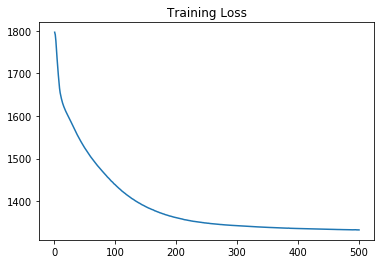

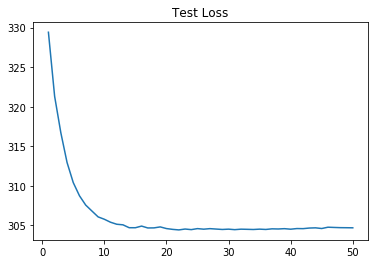

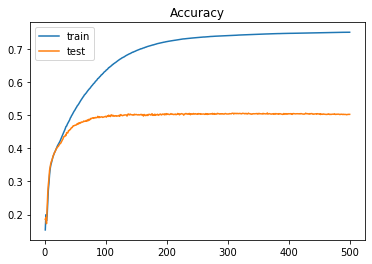

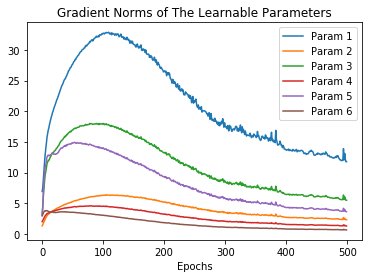

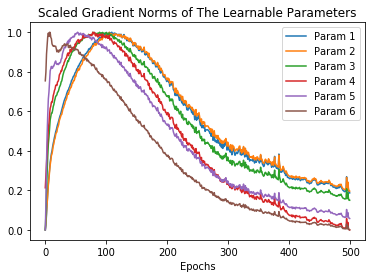

In [7]:
trainer, (train_dataloader, test_dataloader), _ = run_model_trainer(
    batch_size=64,
    learning_rate=1e-3,
    print_trainer_info=True,
    epochs=500
)


### Plotting the Confusion Matrix

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(predicted, actual, title=""):
    cf_matrix = confusion_matrix(predicted, actual)
    cf_matrix = cf_matrix.astype("float") / cf_matrix.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    plt.title(title)
    plt.ylabel("Predicted Label")
    plt.xlabel("Actual Label")
    plt.show()

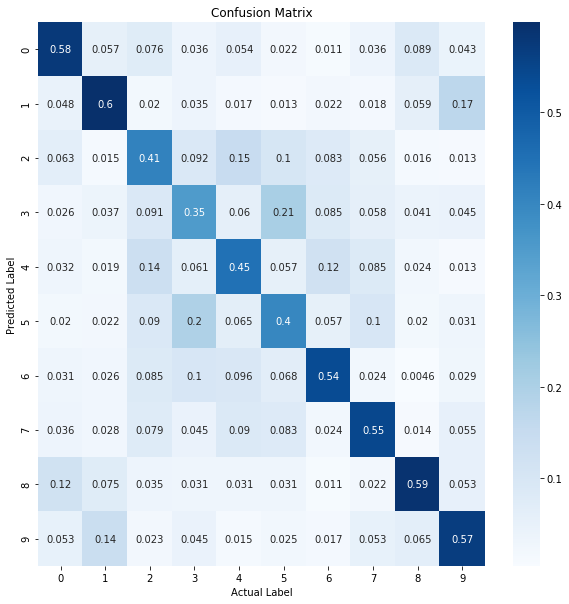

In [9]:
cfPredictedY, cfActualY = trainer.predict_classes(test_dataloader, True)

plot_confusion_matrix(cfPredictedY, cfActualY, title="Confusion Matrix")

### HyperOpt: do random search to select the best parameters

In [10]:
import hyperopt
from hyperopt import hp, fmin, tpe
from sklearn.metrics import f1_score


def tune_learning_rate(search_space_n_times, max_train_epochs):
    def objective(args):
        print(f"\nEvaluating Config: {args}")

        _trainer, (_, _test_dataloader), (_train_acc, _test_acc) = run_model_trainer(
            **args,
            epochs=max_train_epochs,
            track_metrics=False,
            log=False,
            plot_learning_curve=False,
            plot_gradient_norm=False,
        )

        _predicted_labels, _actual_labels = _trainer.predict_classes(_test_dataloader, True)
        score = f1_score(_actual_labels, _predicted_labels, average='weighted')
        print(f"F1 Score: {score}")

        # maximize F1 score
        return -score

    space = {
        "batch_size": hp.choice("batch_size", [32, 64, 128, 256]),
        "learning_rate": hp.loguniform("learning_rate", np.log(1e-4), np.log(0.01)),
    }

    best = fmin(objective, space, algo=tpe.suggest, max_evals=search_space_n_times)

    return hyperopt.space_eval(space, best)


best_params = tune_learning_rate(search_space_n_times=20, max_train_epochs=50)
print("Best Parameters: ", best_params)

                                                      
Evaluating Config: {'batch_size': 128, 'learning_rate': 0.0033500324740081597}
F1 Score: 0.48260996208507595                         
                                                                                   
Evaluating Config: {'batch_size': 256, 'learning_rate': 0.0012569960955452753}
F1 Score: 0.34222376621067                                                         
                                                                                   
Evaluating Config: {'batch_size': 64, 'learning_rate': 0.0031101513072318335}
F1 Score: 0.5021734004274007                                                       
                                                                                   
Evaluating Config: {'batch_size': 128, 'learning_rate': 0.001288847113930028}
F1 Score: 0.37979769237269717                                                     
                                                                         

### HyperOpt: Train with the Best Parameters

Epoch: 10	Training Loss: 788.3201	Training Acc: 0.4440	Test Acc: 0.4340	
Epoch: 20	Training Loss: 756.0441	Training Acc: 0.5311	Test Acc: 0.4795	
Epoch: 30	Training Loss: 734.8810	Training Acc: 0.5857	Test Acc: 0.4946	
Epoch: 40	Training Loss: 718.4618	Training Acc: 0.6276	Test Acc: 0.4992	
Epoch: 50	Training Loss: 705.6339	Training Acc: 0.6602	Test Acc: 0.5021	
Epoch: 60	Training Loss: 696.7132	Training Acc: 0.6812	Test Acc: 0.4998	
Epoch: 70	Training Loss: 689.9421	Training Acc: 0.6968	Test Acc: 0.5047	
Epoch: 80	Training Loss: 683.7582	Training Acc: 0.7120	Test Acc: 0.5078	
Epoch: 90	Training Loss: 679.8606	Training Acc: 0.7211	Test Acc: 0.5098	
Epoch: 100	Training Loss: 675.5818	Training Acc: 0.7308	Test Acc: 0.5092	
Epoch: 110	Training Loss: 673.3112	Training Acc: 0.7356	Test Acc: 0.5067	
Epoch: 120	Training Loss: 671.5771	Training Acc: 0.7396	Test Acc: 0.5063	
Epoch: 130	Training Loss: 670.2298	Training Acc: 0.7430	Test Acc: 0.5076	
Epoch: 140	Training Loss: 669.2576	Training Acc

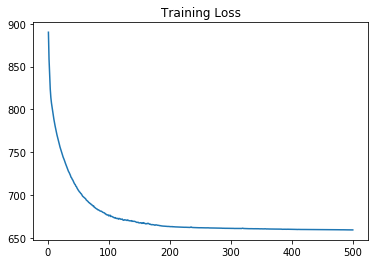

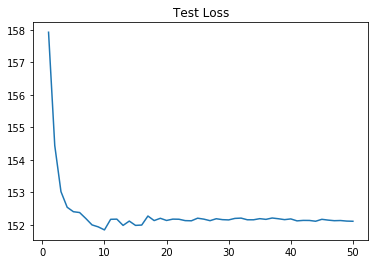

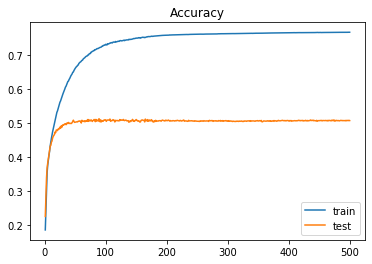

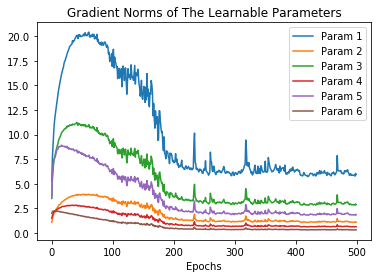

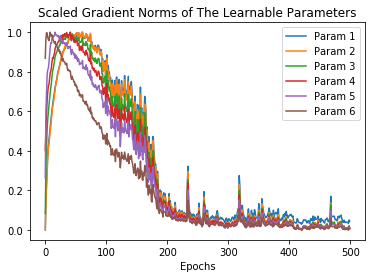

In [11]:
trainer, (train_dataloader, _), _ = run_model_trainer(
    **best_params,
    epochs=500
)